# RUL Prediction Video

In [1]:
import numpy as np
import torch
from pickle import load

# custom modules
from method import compute_eval_matrices,compute_b,ensemble_var,compute_performance_distribution 
from watercan_ import GroupWaterCan
from visualization_website import make_rul_video 

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Get the data

In [3]:
dataset_name='N-CMAPSS' #'uav_data'
threshold=''#'-0.1' #  '+0.1' #

# Load testing varblocks and EOL Causes

In [4]:
with open(f'./data/{dataset_name}/performs_info.pkl', 'rb') as file:
    performs_info=load(file)

with open(f'./data/{dataset_name}/times_test{threshold}.pkl', 'rb') as file:
    times = load(file)

with open(f'./data/{dataset_name}/times_test{threshold}_threshold.pkl', 'rb') as file:
    times_thresholds = load(file)

with open(f'./data/{dataset_name}/RUL_test{threshold}.pkl', 'rb') as file:
    rul= load(file)

with open(f'./data/{dataset_name}/EOLcause_test{threshold}.pkl', 'rb') as file:
    EOLcause= load(file)

performs = {}
thresholds = {}
for name in performs_info.keys():
    with open(f'./data/{dataset_name}/{name}_test{threshold}.pkl', 'rb') as file:
        performs[name] = load(file)
    with open(f'./data/{dataset_name}/{name}_test{threshold}_threshold.pkl', 'rb') as file:
        thresholds[name]= load(file)

EOLcause

['HPT_eff', 'HPT_eff', 'HPT_eff', 'HPT_eff']

## Choose Library

In [5]:
library_exp=f'MTL_2024-08-14_{dataset_name}'

## Load Group Distribution

In [6]:
exp_address=f'./Library/{library_exp}/'

group_distributions={}
for perform_name in performs_info.keys():
    perform_info=performs_info[perform_name]

    perform_address=exp_address+f'{perform_name}/'

    configs=torch.load(perform_address+'config.pth')
    model_state=torch.load(perform_address+'model_state.pth')
    model=GroupWaterCan(configs)
    model.load_state_dict(model_state)
    model.to(device)
    group_distributions[perform_name]=model
times_torch=[torch.tensor(time,device=device,dtype=torch.float32).unsqueeze(dim=1) for time in times]

# Compute and prepare A,b matrices and time

In [7]:
n_test_sys=len(times)
A,S=compute_eval_matrices(group_distributions,times_torch)
test_sys_list=range(n_test_sys)
b = performs
time_sys = times 

## Predicts and plot Performance Curves

In [8]:
n_train_sys =6 # 20
n_paths = 10    # 10 #
gamma={'HI': 100}
ood_coef=0.5

conserv_pred=0.5

In [9]:
exp=f'thre{threshold}_ntrain{n_train_sys}_npaths{n_paths}_pred{conserv_pred}_ood{ood_coef}'
#exp='try'

if exp == 'try':
    n_train_sys =5 #5#
    n_paths =20 #5# 
exp_address=f'Experiments/{dataset_name}/{exp}'

max_life = 100
tol = 1e-4
max_iter = 100
import os
os.makedirs(exp_address, exist_ok=True)

In [10]:
y_lim_={'SOC': (0.7,1),
        'POS':(0,6.1),
        'CUM':(0,28)}
loc_={'SOC': 'lower left',
        'POS':'upper left',
        'CUM':'upper left'}
        
monot_={'SOC':'-', #0.1
        'POS':'+', #0.1 
        'CUM':'+'}

gamma_={'SOC': 100, #0.001, #0.1
        'POS': 100, #0.1, #0.1 
        'CUM': 100} #1

time_est_={'SOC': None, #0.1
        'POS':None, #0.1 
        'CUM':None}

A_est_={'SOC': None, #0.1
        'POS':None, #0.1 
        'CUM':None}

b_est_={'SOC': None, #0.1
        'POS':None, #0.1 
        'CUM':None}



In [11]:
y_lim_={'HI': (0,1)}
loc_={'HI': 'lower left'}
monot_={'HI':'-'}
gamma_={'HI': 100} #1
time_est_={'HI': None}

A_est_={'HI': None}

b_est_={'HI': None}

time_unit='cycle'


In [12]:
num_sys=len(times)
num_sys

4

Moviepy - Building video Experiments/N-CMAPSS/thre_ntrain6_npaths10_pred0.5_ood0.5/System3_pred.mp4.
Moviepy - Writing video Experiments/N-CMAPSS/thre_ntrain6_npaths10_pred0.5_ood0.5/System3_pred.mp4



Moviepy - Done !
Moviepy - video ready Experiments/N-CMAPSS/thre_ntrain6_npaths10_pred0.5_ood0.5/System3_pred.mp4
RMSE_acc: 4.556379975765305
RMSE_csv: 3.7464911267809224
RMSE_pred: 1.066725973460652
RMSE_unc: 12.138752170678956
----------------------------------------------------------------
RMSE_acc mean: 4.556379975765305
RMSE_acc std: 0.0
RMSE_csv mean: 3.7464911267809224
RMSE_csv std: 0.0
RMSE_pred mean: 1.066725973460652
RMSE_pred std: 0.0
RMSE_unc mean: 12.138752170678956
RMSE_unc std: 0.0
----------------------------------------------------------------


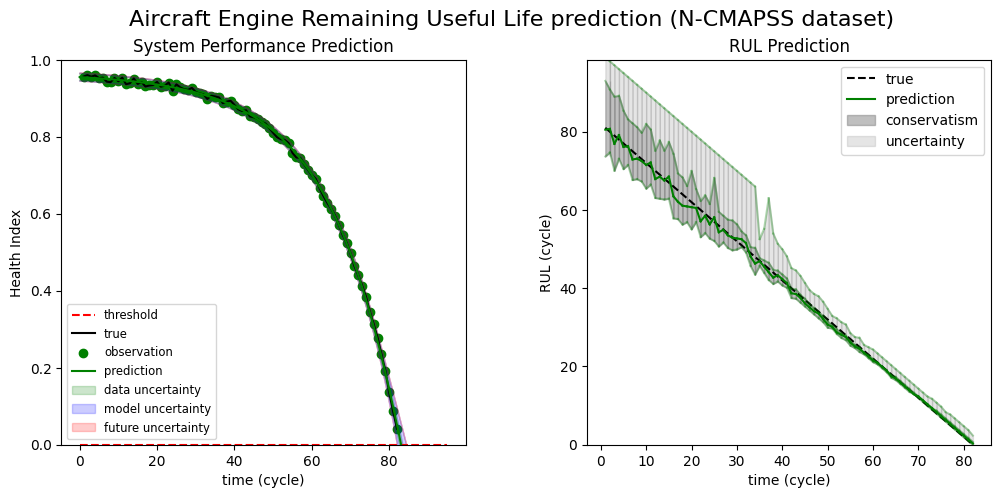

In [13]:
#RUL.data_mode(mode='sys',align='left')

long_life=max([len(time) for time in times])
pred_names='acc','csv','pred','unc'
end_time=int(long_life+5)
density_time=int((long_life+5)*2.5)
t = np.linspace(0, end_time, density_time)

num_sys=len(times)# RUL.shape[0]
if exp=='try': num_sys=1
accel=15*3600
trues = []
RMSEs={key: [] for key in pred_names}
predss={key: [] for key in pred_names}
causess={key: [] for key in pred_names}
for system in range(3,4): 
        group_distribution_={}
        A_={}
        S_={}
        b_={}
        threshold_={}
        for name in performs_info.keys():
                group_distribution_[name]=group_distributions[name].get_sub_watercan(range(n_train_sys))
                A_[name]= A[name][system][:,:n_train_sys]
                S_[name]= S[name][system][:,:n_train_sys]
                b_[name]= b[name][system]

                threshold=np.interp(t, times_thresholds[system], thresholds[name][system])
                threshold_[name]=torch.tensor(threshold,dtype=torch.float32,device=device)

        perform_info={'monot':monot_,
                        'threshold': threshold_,
                        'group_networks':group_distribution_,
                        'A': A_,
                        'b' : b_,
                        'S' : S_,
                        'gamma': gamma_,
                        'y_lim': y_lim_,
                        'loc' : loc_,
                        'time_est':time_est_,
                        'A_est':A_est_,
                        'b_est':b_est_,
        }
        preds,causes=make_rul_video(system,t,time_sys[system],rul[system],EOLcause[system],**perform_info, time_unit=time_unit,
                                n_train_sys=n_train_sys, n_paths=20, ood_coef=ood_coef,
                                max_life = max_life,tol = tol,max_iter = max_iter,
                                accel=accel//3600, save=exp_address,conserv=conserv_pred)
        y_true=rul[system]

        for name in pred_names:
                RMSE=np.sqrt(np.mean((preds[name]-y_true)**2))
                print(f"RMSE_{name}: {RMSE}")
                RMSEs[name].append(RMSE)
                predss[name].append(preds[name])
                causess[name].append(causes[name])
        trues.append(y_true)

torch.save(predss,f'{exp_address}/preds.pt')
torch.save(causess,f'{exp_address}/causes.pt')
torch.save(trues,f'{exp_address}/trues.pt')
print('----------------------------------------------------------------')
for name in pred_names:
        print(f"RMSE_{name} mean: {np.mean(RMSEs[name],axis=0)}")
        print(f"RMSE_{name} std: {np.std(RMSEs[name],axis=0)}")
print('----------------------------------------------------------------')

In [14]:
pred_names='acc','csv','pred','unc'

predss=torch.load(f'{exp_address}/preds.pt')
trues=torch.load(f'{exp_address}/trues.pt')

In [15]:
pred_names='acc','csv','pred','unc'

predss=torch.load(f'{exp_address}/preds.pt')
trues=torch.load(f'{exp_address}/trues.pt')

In [16]:
for name in pred_names:
        print(f'------------------------------- {name} RMSE -------------------------------')
        RMSEs=[]
        for system in range(len(trues)):
                RMSE=np.sqrt(np.mean((predss[name][system]-trues[system])**2))
                print(f"system {system}: {RMSE}")
                RMSEs.append(RMSE)
        print('----------------------------------')
        print(f"RMSE_{name} mean: {np.mean(RMSEs,axis=0)}")
        print(f"RMSE_{name} std: {np.std(RMSEs,axis=0)}")
        print('----------------------------------')

------------------------------- acc RMSE -------------------------------
system 0: 4.556379975765305
----------------------------------
RMSE_acc mean: 4.556379975765305
RMSE_acc std: 0.0
----------------------------------
------------------------------- csv RMSE -------------------------------
system 0: 3.7464911267809224
----------------------------------
RMSE_csv mean: 3.7464911267809224
RMSE_csv std: 0.0
----------------------------------
------------------------------- pred RMSE -------------------------------
system 0: 1.066725973460652
----------------------------------
RMSE_pred mean: 1.066725973460652
RMSE_pred std: 0.0
----------------------------------
------------------------------- unc RMSE -------------------------------
system 0: 12.138752170678956
----------------------------------
RMSE_unc mean: 12.138752170678956
RMSE_unc std: 0.0
----------------------------------


In [17]:
exp_address

'Experiments/N-CMAPSS/thre_ntrain6_npaths10_pred0.5_ood0.5'